<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Coding the Matrix Method in Python - Notebook 3.1 (In-class examples)
    
In this notebook we discuss the implementation in Python of the theory discussed in Lecture 3 (Q3). We start by defining the classes and performing some sanity checks on simple bars and beams. We then move on to a more complicated frame structure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydynsm as PDM

## The Node class
The purpose of this class is to store node information and keep track of the total number of DOFs of the problem. Note the automatic bookkeeping we introduce in `__init__`. This simple but efficient way of keeping track of which DOFs belong to which nodes will make life much easier when we need to assemble matrices from multiple elements. **The code below does not need any modification**.

## The Element class
This class keeps track of each element in the model, including:
- Cross-section properties
- Element orientation (for coordinate system transformations)
- Which Nodes make up each element, and in turn (with help of the Node class) which DOFs belong to each element

Apart from bookkeeping element data, the other main task of this class is to provide the element stiffness matrix in the global coordinate system (for subsequent assembly) and postprocess element-level fields.

Here the class describes an element combining extension and Euler-Bernoulli bending in dynamics. A similar (or inherited) class could also be implemented for different element types (*e.g.* Timoshenko beam, tensioned string, rod in torsion, etc). Here we also keep it simple by assuming elements are all arranged in a 2D plane. 

Please note that, in contrast to statics, the dynamic characterisation of the elements requires the dependency on the excitation frequency which is introduced by the variable "omega". Moreover, all structural systems have damping which is here introduced through the variable "ksi" into the elasticity modulus of the element.

## The Constrainer class

This small class keeps track of which DOFs have prescribed displacements and takes care of applying these constraints to the global $\mathbf{K}$ and $\mathbf{f}$. For now we keep it simple and assume all constraints fix the DOF values to zero. For the first two examples you can use this class as it is. For the third assignment, a short new function should be implemented (see below).

## Sanity check #1: Bar in extension

Having made our implementations, we now check them with two simple examples that serve as sanity checks. The first is a simple bar undergoing extension:

<center><figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/extpointload.png" WIDTH=200 ALIGN="center">
      </figure></center>

Use the code blocks below to set up and solve this problem using the classes above.

### initialize assembler

Firstly, initialise an assembler with a project name you like, like `1D Rod` here. Make sure this is done whenever you start solving a new problem.

In [2]:
# initialise assember
Assembler = PDM.Assembler
s1 = Assembler('1D rod',analysis_type='new')

Assembler '1D rod' successfully initialised


### Parameters

We define the parameters here for convenience. 

In [3]:
E = 210e9
EA = 7e6
A = EA/E
EI = 1.5 * 7e06
I = EI/E
W = I
rhoA = 1e03 
rho = rhoA/A
L  = 1
ksi = 0.01
omega_f = 100
F = 1e06

### Create nodes

Create two nodes here using `CreateNode(A,B)` from the class `assembler`. You can store them on a `list` or simply create them as two separate objects (*e.g.* `node1` and `node2`). 

**TIP**: Take a look at which arguments the `__init__` function of the `node` class receives!

In [4]:
node1 = s1.CreateNode(0,0)
node2 = s1.CreateNode(L,0)

### Create element

Here we only have a single element, so there is no need to store it in a `list` yet. You are also going to need a `dict` defining the cross-section of the element.

**TIP**: See what `__init__` of the `Element` class expects. Also check the `set_section` function.

In [5]:
elem = s1.CreateElement([node1, node2])
elem.SetSection('Rod', {'E': E, 'A':A, 'rho':rho, 'ksi':ksi})

Successfully added element of type: Rod to Element 0


### Loading definition

Here we define a simple harmonic loading in frequency domain for given frequency `omega_f`

In [6]:
F_0 = lambda omega: F if omega == omega_f else 0

### Set boundary conditions

Use `fix_node()` function from `node` class to contrain 

- all DoFs of `node1` 
- $z$ and $\varphi_{yy}$ of `node2`

**TIP**: You also need to pass the load $F$ on to Node 2. Check the member functions of `Node` to infer how that should be done.

In [7]:
node1.fix_node('x','z','phi_y')
node2.fix_node('z','phi_y')
node2.add_load(x=F_0)

Global DOF 'x' for node 0 updated to 0.
Local DOF 'x' updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 0 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 0 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'z' for node 1 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 1 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.


### Assemble the system of equations

Since we only have one element, there is no real assembly to be performed other than getting the stiffness matrix of the single element and storing the load at Node 2 in the correct positions of $\mathbf{f}$. To avoid confusion, we do this part for you. Just take care to change the name of the element or of Node 2 in case you used something different.

In [8]:
s1.run_connectivity()
K_global = s1.GlobalStiffness(omega_f)
F_global = s1.GlobalForce(omega_f)
print(F_global)

[      0.+0.j       0.+0.j       0.+0.j 1000000.+0.j       0.+0.j
       0.+0.j]


### Constrain the problem and solve for nodal displacements

Try to solve for $u$ as it is written in this block. You will notice that `K_global` is singular. Why is that the case? 

**TIP**: Use the `.GlobalConstrainedStiffness(Omega)` and  `.GlobalConstrainedForce(Omega)`

In [9]:
Kc_global = s1.GlobalConstrainedStiffness(omega_f)
Fc_global = s1.GlobalConstrainedForce(omega_f)
u_free = s1.SolveUfree(Kc_global, Fc_global)
print(u_free)

[0.30250885-0.01361971j]


### Compare with the solution you know

Finally, compare the displacement of the only one free DoF $u$ at the end of the bar with the one coming from the ODE solution. 

**TIP**: Remember the DOF ordering we assume ($\left[u\,\,w\,\,\varphi\right]$) and the order we use to create our nodes (check `__init__` of the `Node` class one more time!)

In [10]:
print('ODE solution (0.30250884529318846290, - 0.013619705006987083063 j)','Matrix method solution',u_free) 
# CHECK MAPLE FILE FOR ANALYTICAL DERIVATIONS

ODE solution (0.30250884529318846290, - 0.013619705006987083063 j) Matrix method solution [0.30250885-0.01361971j]


## Sanity check #2: Cantilever beam

<center><figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/cantilever.png" WIDTH=200 ALIGN="center">
      </figure></center>
    
In the first example above we tested our model under extension. But that does not really guarantee it will behave correctly in bending! That is the goal of this second sanity check. Proceed as before and check with the MAPLE solution:
    
When setting up and solving your model, note that we are now interested in $w$ displacements, our load is now vertical.

### Parameters

In [11]:
s2 = Assembler('1D Beam',analysis_type='new')
E = 210e9
EA = 7e6
A = EA/E
EI = 1.5 * 7e06
I = EI/E
W = I
rhoA = 1e03 
rho = rhoA/A
L  = 1
ksi = 0.01
omega_f = 100
F = 1e06

Assembler '1D Beam' successfully initialised


### Create nodes

In [12]:
node1 = s2.CreateNode(0,0)
node2 = s2.CreateNode(L,0)

### Create element

In [13]:
elem = s2.CreateElement([node1, node2])
elem.SetSection('EulerBernoulli Beam', {'E': E, 'rho':rho, 'A':A, 'Ib':I, 'ksi':ksi, 'Wb':I})

Successfully added element of type: EulerBernoulli Beam to Element 1


### Loading definition

Here we define a simple harmonic loading in frequency domain for given frequency `omega_f`

In [14]:
F_0 = lambda omega: -F if omega == omega_f else 0

### Set boundary conditions

In [15]:
node1.fix_node('x','z','phi_y')
node2.fix_node('x')
node2.add_load(z=F_0)

Global DOF 'x' for node 2 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 2 updated to 0.
Local DOF 'z' updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 2 updated to 0.
Local DOF 'phi_y' updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'x' for node 3 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.


### Assemble the system of equations

In [16]:
s2.run_connectivity()
K_global = s2.GlobalStiffness(omega_f)
F_global = s2.GlobalForce(omega_f)

### Constrain the problem and solve for nodal displacements

In [17]:
Kc_global = s2.GlobalConstrainedStiffness(omega_f)
Fc_global = s2.GlobalConstrainedForce(omega_f)
u_free = s2.SolveUfree(Kc_global, Fc_global)
print(u_free)

[-0.0343037 +0.00074182j  0.05114355-0.00109971j]


### Check with the solution you know

In [18]:
print('Analytical solution: (0.0343036985883241-0.000741815967655428j)','Matrix method solution',np.abs(u_free[0]))

Analytical solution: (0.0343036985883241-0.000741815967655428j) Matrix method solution 0.034311718519602505


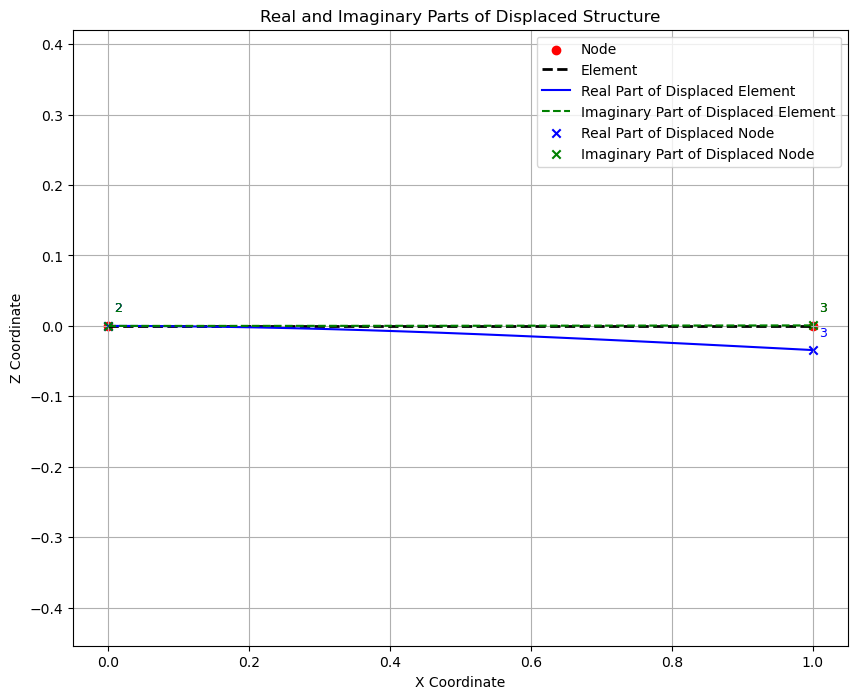

In [19]:
u_elem = s2.FullDisplacement(u_free)
disp = s2.ElementDisplacements(u_elem, omega_f)
s2.PlotElementDisplacements(disp,scale=1)

## Sanity check #3: In-plane frame

<center><figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/vierendeel.png" WIDTH=400 ALIGN="center">
      </figure></center>

In order to solve the problem, you need to improve the classes we define above:
- Right now elements are not rotated to the global system. Implement the correct rotation matrix in the `__init__` function of the `Element` class in order to allow for members with different orientations
- At the moment the `Constrainer` class can only fix all DOFs of a node. Implement a more flexible `fix_dof` function that allows for only certain DOFs to be fixed. Remember our classes assume the DOF order $\left[u\,\, w\,\,\varphi\right]$ that should always be consistent throughout the implementation

Additionally, note that the sanity checks above only had a single element. For this model you need to obtain $\mathbf{K}$ and $\mathbf{f}$ of all elements and add them to the correct locations in the global stiffness matrix and force vector. To do that, make use of the `global_dofs` function of the Element class and the `np.ix_` Numpy utility function. (**TIP**: refer back to the contents of week 2.2 of MUDE!)

You can use the blocks below to develop your answer. Feel free to create new Markdown headers as needed, but otherwise use the ones provided to split your solution into logical parts.

In [20]:
s3 = Assembler('In-plane frame',analysis_type='new')

Assembler 'In-plane frame' successfully initialised


### Parameters

In [21]:
h = 1
b = 1
E = 210e9
EIr = 1e6 # MODIFIED
Ir = EIr/E
EIk = 1e5 # MODIFIED
Ik = EIk/E
EA = 1e10 # MODIFIED
A = EA/E
H  = 1e5
rhoA = 2e03  # MODIFIED
rho = rhoA/A
omega = 0.001  # MODIFIED
ksi = 0.01 # MODIFIED

### Create nodes

In [22]:
nodes = []

nodes.append(s3.CreateNode(0,0))
nodes.append(s3.CreateNode(b,0))
nodes.append(s3.CreateNode(b,h))
nodes.append(s3.CreateNode(0,h))

### Create elements

In [23]:
elems = []

elems.append(s3.CreateElement([nodes[0], nodes[1]]))
elems.append(s3.CreateElement([nodes[1], nodes[2]]))
elems.append(s3.CreateElement([nodes[2], nodes[3]]))
elems.append(s3.CreateElement([nodes[0], nodes[3]]))

beams = {}
columns = {}
beams['E'] = E
beams['A'] = A
beams['Ib'] = Ir
beams['Wb'] = Ir
beams['ksi'] = ksi
beams['rho'] = rho

columns['E'] = E
columns['A'] = A
columns['Ib'] = Ik
columns['Wb'] = Ik
columns['ksi'] = ksi
columns['rho'] = rho

rods = {}
rods['E'] = E
rods['A'] = A
rods['rho'] = rho

elems[0].SetSection ('EulerBernoulli Beam',beams)
elems[1].SetSection ('EulerBernoulli Beam',columns)
elems[2].SetSection ('EulerBernoulli Beam',beams)
elems[3].SetSection ('EulerBernoulli Beam',columns)

for elem in elems:
    elem.SetSection ('Rod',rods)


Successfully added element of type: EulerBernoulli Beam to Element 2
Successfully added element of type: EulerBernoulli Beam to Element 3
Successfully added element of type: EulerBernoulli Beam to Element 4
Successfully added element of type: EulerBernoulli Beam to Element 5
Successfully added element of type: Rod to Element 2
Successfully added element of type: Rod to Element 3
Successfully added element of type: Rod to Element 4
Successfully added element of type: Rod to Element 5


###  Define loading

In [24]:
H_0 = lambda omega: -H if omega == omega_f else 0

### Set boundary conditions

In [25]:
nodes[1].fix_node('z')
nodes[0].fix_node('x','z')
nodes[3].add_load(x=H_0)

Global DOF 'z' for node 5 updated to 0.
Local DOF 'z' updated to 0.
Global DOF 'z' for node 5 updated to 0.
Local DOF 'x' updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'x' for node 4 updated to 0.
Local DOF 'x' updated to 0.
Global DOF 'x' for node 4 updated to 0.
Local DOF 'z' updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 4 updated to 0.
Local DOF 'z' updated to 0.
Global DOF 'z' for node 4 updated to 0.
Local DOF 'x' updated to 0.
Global DOF 'z' with value '0' applied to connected elements.


### Assemble the system

In [26]:
s3.run_connectivity()
K_global = s3.GlobalStiffness(omega_f)
F_global = s3.GlobalForce(omega_f)

### Constrain the problem and solve for nodal displacements

In [27]:
Kc_global = s3.GlobalConstrainedStiffness(omega_f)
Fc_global = s3.GlobalConstrainedForce(omega_f)
u_free = s3.SolveUfree(Kc_global, Fc_global)

### Postprocess results

In [28]:
u_elem = s3.FullDisplacement(u_free)
disp = s3.ElementDisplacements(u_elem, omega_f)
forces = s3.ElementForces(u_elem, omega_f)

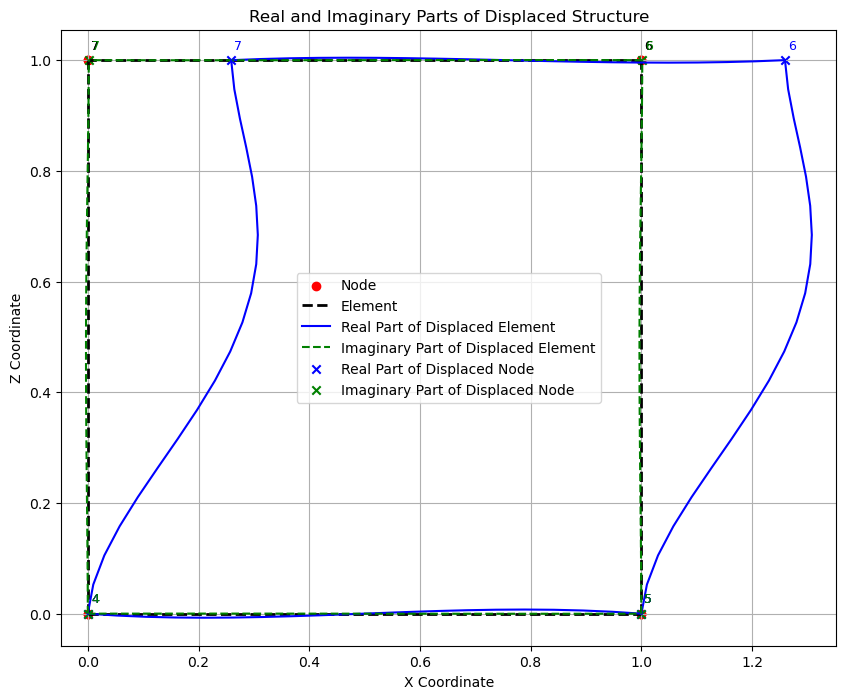

In [29]:
s3.PlotElementDisplacements(disp,scale=100)

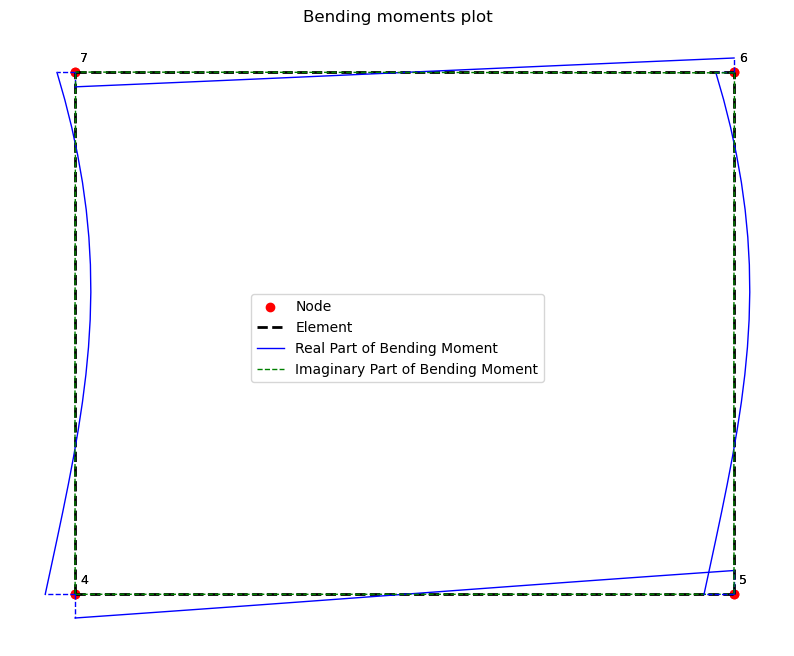

In [30]:
s3.PlotMoments(forces,scale=1e-5)